# Geophysical Indices
Geophysical indices are standard parameters that charaterize the global geomagnetic conditions and activity at a particular time.  These have standard definitions and are available from a variety of sources.  We will use the files hosted by [GFZ Potsdam](https://www.gfz-potsdam.de/en/kp-index/). The FTP site hosts yearly ASCII files that include the Kp, ap, and Ap indices, as well as the International Sunspot Number and the F10.7 Solar Radio Flux.

In [1]:
import os
from ftplib import FTP
import datetime as dt
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Download a file
Yearly files are avialable from the [Potsdam FTP site](ftp://ftp.gfz-potsdam.de/pub/home/obs/Kp_ap_Ap_SN_F107).  These can be downloaded with the following code.

In [2]:
year = 2015

source_site = 'ftp.gfz-potsdam.de'
ftp = FTP(source_site)
ftp.login()
filename = 'Kp_ap_Ap_SN_F107_{:4}.txt'.format(year)

with open(os.path.join(filename), 'wb') as lf:
    ftp.retrbinary('RETR /pub/home/obs/Kp_ap_Ap_SN_F107/{}'.format(filename), lf.write)
ftp.quit()


'221-You have transferred 61564 bytes in 1 files.\n221-Total traffic for this session was 63431 bytes in 1 transfers.\n221-Thank you for using the FTP service on ftp.\n221 Goodbye.'

## Read in a file
These ASCII files are fairly simple and consist of whitespace delimited values that can be read in with the numpy loadtxt function.  From the file header:

In [3]:
data = np.loadtxt(filename)

### Retrive indices for a particular time
To retrieve indices for a particular date/time, simpily select the line from the data array that corresponds to the day in question.  For the parameters that depend on time of day (Kp and ap), you can select the correct value by dermining which 3-hour block the time lies within.

In [4]:
targtime = dt.datetime(2015,2,7,11,4,0)

# Find which line corresponds to 
lidx = np.argwhere((data[:,0]==targtime.year) & (data[:,1]==targtime.month) & (data[:,2]==targtime.day)).flatten()[0]
# Select that line from the data array
gpi_values = data[lidx]

# Find which 3-hour indices should be used
hidx = targtime.hour // 3

# For convenience, save in a dictionary
gpi_idx = {'Bsr':5, 'dB':6, 'Kp':7+hidx, 'ap':15+hidx, 'Ap':23, 'SN':24, 'F10.7obs':25, 'F10.7adj':26}
gpi_out = {k:gpi_values[i] for k,i in gpi_idx.items()}

for k, v in gpi_out.items():
    print(k, v)

Bsr 2476.0
dB 15.0
Kp 3.333
ap 18.0
Ap 9.0
SN 76.0
F10.7obs 153.0
F10.7adj 148.9


### Create arrays of indices for a range of times
Similarly, the indices can be extracted over a range of times.

In [7]:
starttime = dt.datetime(2015,2,1)
endtime = dt.datetime(2015,3,1)

time_array = np.array([starttime+dt.timedelta(hours=h) for h in np.arange((endtime-starttime).total_seconds()/3600)])

gpi_dates = np.array([dt.date(int(d[0]),int(d[1]),int(d[2])) for d in data])
gpi_idx = {'Bsr':5, 'dB':6, 'Kp':7, 'ap':15, 'Ap':23, 'SN':24, 'F10.7obs':25, 'F10.7adj':26}
gpi_out = {k:list() for k in gpi_idx.keys()}

for t in time_array:
    lidx = np.argwhere(t.date()==gpi_dates).flatten()[0]
    
    # Find which 3-hour indices should be used
    hidx = t.hour // 3

    for k, i in gpi_idx.items():
        if k=='Kp' or k=='ap':
            gpi_out[k].append(data[lidx,i+hidx])
        else:
            gpi_out[k].append(data[lidx,i])

gpi_out = {k:np.array(v) for k,v in gpi_out.items()}


## Plot Geophsical Indices
Create a simple plot of the Kp, ap, Ap, sunspot Number (SN), and adjusted F10.7 Solar Radio Flux (F10.7adj).

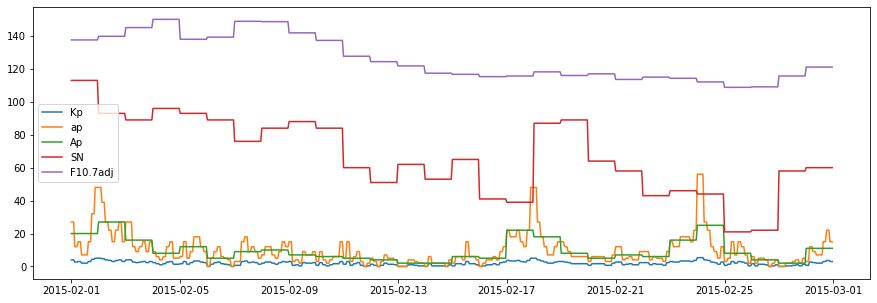

In [8]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for k in ['Kp', 'ap', 'Ap', 'SN', 'F10.7adj']:
    ax.plot(time_array, gpi_out[k], label=k)
    
ax.legend()

## Save Output File
Save indices to an output drivers hdf5 file.

In [10]:
utime = np.array([(t-dt.datetime.utcfromtimestamp(0)).total_seconds() for t in time_array])

with h5py.File('sample_drivers.h5', 'w') as h5:
    h5.create_dataset('UnixTime', data=utime)
    for k, v in gpi_out.items():
        h5.create_dataset(k, data=v)